In [1]:
import random
from os import path

import numpy as np
import torch
import torchvision.transforms as transforms
from torchsummary import summary

import dataloaders
import networks.cdcgan as cdcgan
import networks.utils as utils

### Setup CUDA / Multiprocessing related variables

In [2]:
USE_CUDA = True

if USE_CUDA and torch.cuda.is_available():
    device = 'cuda'  #alt: "cuda:0"
else:
    device = 'cpu'

PIN_MEMORY = True
USE_MULTI_PROCESS_DATA_LOADING = True
# Multi Process Data Loading
if USE_MULTI_PROCESS_DATA_LOADING:
    NUM_THREADS = torch.get_num_threads()
    print("Number of Threads: ", NUM_THREADS)
else:
    NUM_THREADS = 0
    print("Not using Multi-Process Data Loading.")

Number of Threads:  8


### Setup Parameters

In [3]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED);

In [4]:
### Data
DATA_PATH = path.join("data", "tmdb-64")
TABLE_PATH = path.join("data", "tmdb-movies-220915-clean.pkl")

### Architecture
IMAGE_SIZE = 64
IMAGE_SIZE_RATIO = 3  # height/width
NUM_IMG_CHANNELS = 3
NUM_NOISE_VEC_CHANNELS = 100
NUM_FEATURE_VEC_CHANNELS = 37
BASE_NUM_OUT_CHANNELS_G = 128
BASE_NUM_OUT_CHANNELS_D = 64
PADDING_MODE = "reflect"
COLORMODE = "RGB"

### Training
BATCH_SIZE = 128
NUM_EPOCHS = 10
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999

### Visualization
NUM_SAMPLES = 64

### Saving
OUT_PATH = path.join("output-runs", "cdcgan-output")
SAVE_MODEL_EVERY_N_EPOCHS = 1
SAVE_FAKES_EVERY_N_EPOCHS = 1

#MODEL_TO_LOAD = path.join(OUT_PATH, "2022-09-25_18-04-30/gan_at_epoch_0001.pt")
MODEL_TO_LOAD = None

### Load dataset

In [5]:
# Poster subset:
GENRE = None
GENRE_LOGIC = 'and'
OG_LANG = None
YEAR = None
RUNTIME = (40, np.inf)
MAX_NUM = None
SORT = None

# define dataset
poster_dataset = dataloaders.PosterDataset(table_path=TABLE_PATH, img_root_path=DATA_PATH,
                                           img_transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                                           colormode=COLORMODE,
                                           img_in_ram=False,
                                           genre=GENRE, genre_logic=GENRE_LOGIC, og_lang=OG_LANG, year=YEAR,
                                           runtime=RUNTIME,
                                           max_num=MAX_NUM, sort=SORT)
posterloader = torch.utils.data.DataLoader(poster_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                           num_workers=NUM_THREADS, pin_memory=True)

Sample dataset:

The dataset has 224094 entries.


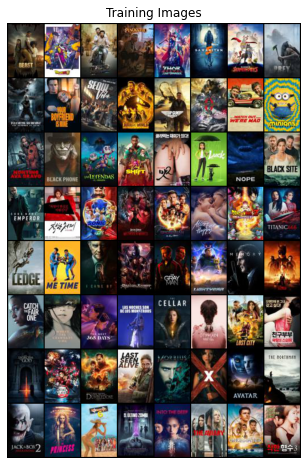

In [6]:
sample_reals = utils.sample_posters(posterloader, number_of_samples=NUM_SAMPLES, colormode=COLORMODE, device=device)
print('The dataset has ' + str(len(poster_dataset)) + ' entries.');

In [7]:
sample_labels = torch.stack(sample_reals[6:43], dim=1).type(torch.FloatTensor).to(device)[:NUM_SAMPLES]
sample_labels_generator = sample_labels[:, :, None, None].expand(NUM_SAMPLES, NUM_FEATURE_VEC_CHANNELS, 3, 1)

### Initialize Network

In [8]:
generator, discriminator = cdcgan.create_gan(num_img_channels=NUM_IMG_CHANNELS,
                                             num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS,
                                             base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G,
                                             base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D, padding_mode=PADDING_MODE,
                                             num_feature_vec_channels=NUM_FEATURE_VEC_CHANNELS, device=device)

print("Generator:")
summary(generator, input_size=[(NUM_NOISE_VEC_CHANNELS, 3, 1), (NUM_FEATURE_VEC_CHANNELS, 3, 1)])
print("\nDiscriminator:")
summary(discriminator, input_size=[(3, 96, 64), (NUM_FEATURE_VEC_CHANNELS, 96, 64)])

Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 6, 4]         819,200
       BatchNorm2d-2            [-1, 512, 6, 4]           1,024
   ConvTranspose2d-3            [-1, 512, 6, 4]         303,104
       BatchNorm2d-4            [-1, 512, 6, 4]           1,024
   ConvTranspose2d-5           [-1, 512, 12, 8]       8,388,608
       BatchNorm2d-6           [-1, 512, 12, 8]           1,024
   ConvTranspose2d-7          [-1, 256, 24, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 24, 16]             512
   ConvTranspose2d-9          [-1, 128, 48, 32]         524,288
      BatchNorm2d-10          [-1, 128, 48, 32]             256
  ConvTranspose2d-11            [-1, 3, 96, 64]           6,144
Total params: 12,142,336
Trainable params: 12,142,336
Non-trainable params: 0
----------------------------------------------------------------
Input size (M

In [9]:
from contextlib import redirect_stdout

with open(path.join(OUT_PATH, "architectures.txt"), "w") as file:
    with redirect_stdout(file):
        print("Generator:")
        summary(generator, input_size=[(NUM_NOISE_VEC_CHANNELS, 3, 1), (NUM_FEATURE_VEC_CHANNELS, 3, 1)])
        print("\nDiscriminator:")
        summary(discriminator, input_size=[(3, 96, 64), (NUM_FEATURE_VEC_CHANNELS, 96, 64)])

In [10]:
trainer = cdcgan.create_trainer(out_dir=OUT_PATH, num_samples=NUM_SAMPLES, colormode=COLORMODE,
                                num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, image_size_ratio=IMAGE_SIZE_RATIO,
                                d_params=discriminator.parameters(), g_params=generator.parameters(),
                                learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2, device=device)

## Train

In [11]:
SHOW_GRAPHS = False

trainer.train(generator, discriminator, num_features=NUM_FEATURE_VEC_CHANNELS, dataloader=posterloader,
              num_epochs=NUM_EPOCHS, device=device, fake_img_snap=SAVE_FAKES_EVERY_N_EPOCHS,
              model_snap=SAVE_MODEL_EVERY_N_EPOCHS, model_to_load=MODEL_TO_LOAD, show_graphs=SHOW_GRAPHS,
              sample_labels_generator=sample_labels_generator)

[0/9]	Loss_D: 0.9517	Loss_G: 2.1799	D(x): 0.5889	D(G(z)): 0.1430 / 0.1763: 100%|██████████| 1751/1751 [13:04<00:00,  2.23it/s]
[1/9]	Loss_D: 0.8018	Loss_G: 3.3767	D(x): 0.7779	D(G(z)): 0.3011 / 0.0656: 100%|██████████| 1751/1751 [12:02<00:00,  2.42it/s]
[2/9]	Loss_D: 1.1494	Loss_G: 1.1156	D(x): 0.4798	D(G(z)): 0.0519 / 0.4577: 100%|██████████| 1751/1751 [11:08<00:00,  2.62it/s]
[3/9]	Loss_D: 0.6285	Loss_G: 2.1473	D(x): 0.6991	D(G(z)): 0.1022 / 0.2036: 100%|██████████| 1751/1751 [09:53<00:00,  2.95it/s]
[4/9]	Loss_D: 0.3202	Loss_G: 5.0040	D(x): 0.9046	D(G(z)): 0.1443 / 0.0139: 100%|██████████| 1751/1751 [09:49<00:00,  2.97it/s] 
[5/9]	Loss_D: 2.4993	Loss_G: 0.4682	D(x): 0.2267	D(G(z)): 0.0163 / 0.6761: 100%|██████████| 1751/1751 [10:40<00:00,  2.73it/s] 
[6/9]	Loss_D: 0.3578	Loss_G: 3.9231	D(x): 0.8072	D(G(z)): 0.0328 / 0.0769: 100%|██████████| 1751/1751 [10:34<00:00,  2.76it/s] 
[7/9]	Loss_D: 0.1421	Loss_G: 5.6497	D(x): 0.9231	D(G(z)): 0.0214 / 0.0351: 100%|██████████| 1751/1751 [10:08

### Show results

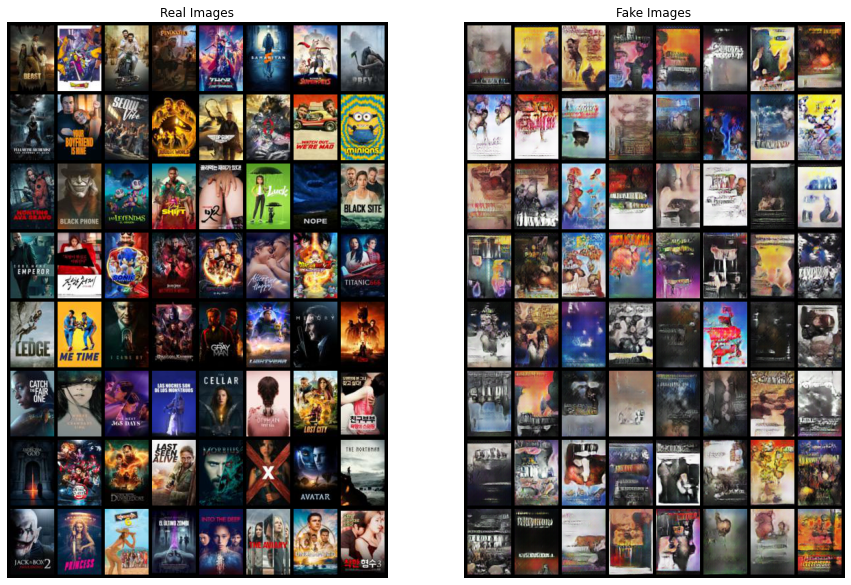

In [12]:
utils.plot_reals_vs_fakes(generator, trainer, sample_reals, NUM_SAMPLES,
                          path.join(trainer.last_out_dir, "real_vs_fake.png"), device,
                          sample_labels_generator=sample_labels_generator)

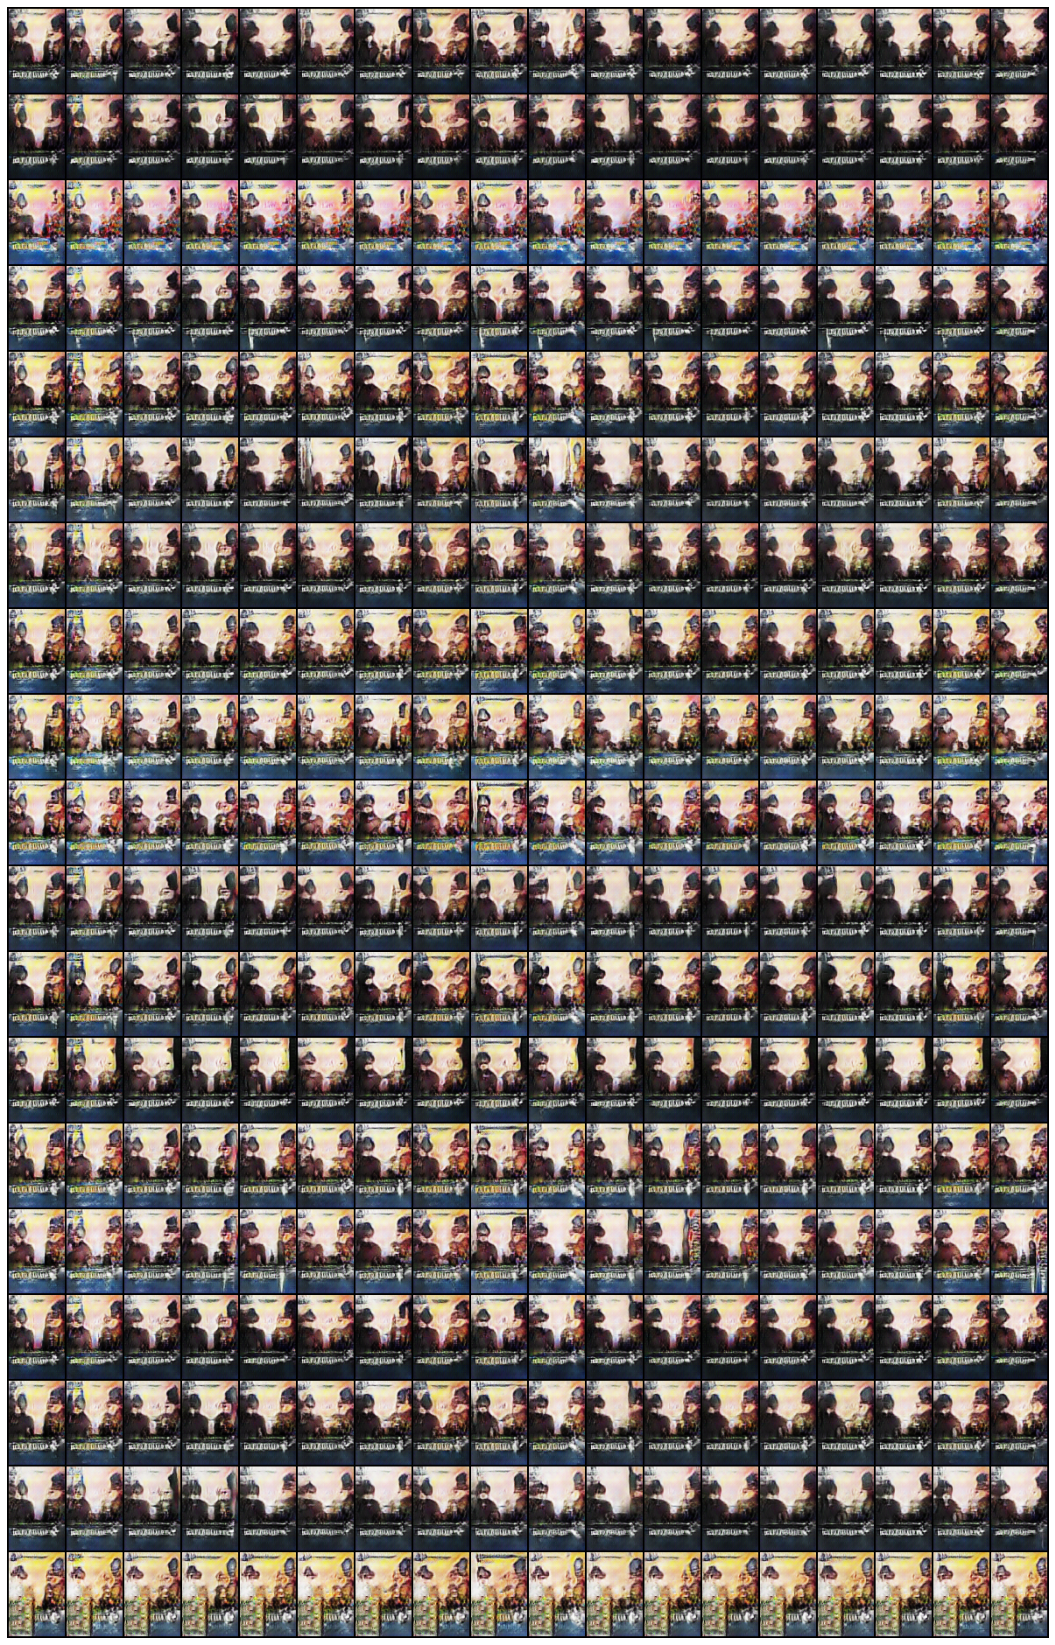

In [13]:
seed = 79469812346923649
utils.plot_grid(generator, NUM_NOISE_VEC_CHANNELS, device, seed, 20, 30,
                output=path.join(trainer.last_out_dir, "conditional_grid.png"))